## ReWOO Agent

##### Load the environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')

##### Model

In [ ]:
from langchain_aws import ChatBedrock
model = ChatBedrock(model=model_id)

##### State

In [27]:
from typing import List
from typing_extensions import TypedDict

class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str


In [28]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [29]:
import re

from langchain_core.prompts import ChatPromptTemplate

def get_plan(state: ReWOO):
    task = state["task"]

    prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
    planner = prompt_template | model

    result = planner.invoke({"task": task})
    
    # Find all matches in the sample text
    # Regex to match expressions of the form E#... = ...[...]
    regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
    matches = re.findall(regex_pattern, result.content)

    #return matches
    return {"steps": matches, "plan_string": result.content}

In [30]:
def _get_current_task(state: ReWOO):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os
search = TavilySearchResults()

def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

In [32]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"

    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

In [33]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [34]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)

graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

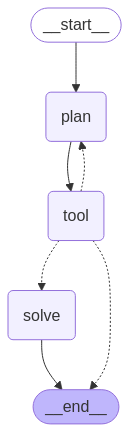

In [35]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
task = "what is the exact hometown of the 2024 mens australian open winner"
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [("First, I need to find out who won the 2024 Australian Open men's singles title.", '#E1', 'Google', '"who won 2024 australian open mens singles"'), ('Once I know the winner, I need to find their specific hometown (not just country, but the actual city/town they were born in).', '#E2', 'Google', '"Jannik Sinner birthplace hometown where was he born"'), ('To ensure accuracy and get confirmation about the exact hometown details.', '#E3', 'LLM', 'Using #E1 and #E2, please confirm the exact hometown of Jannik Sinner. Be specific about the locality and region.'), ('If needed, verify any discrepancy in hometown information with an additional search targeting local/Italian sources.', '#E4', 'Google', '"dove è nato Jannik Sinner luogo di nascita esatto"')], 'plan_string': 'Let me break this down step by step:\n\nPlan: First, I need to find out who won the 2024 Australian Open men\'s singles title.\n#E1 = Google["who won 2024 australian open mens singles"]\n\nPlan: Once I kn